# Data Exploration of Quora Questions
## Using Word2Vec and t-SNE 


Below, I explore a dataset of Quora questions. I train word2vec on the dataset to generate vector representations of words found in training data set questions, and then I use t-SNE to visualize some of the high-dimensional data stored in the word2vec model and understand how the word2vec model looks.

The data comes from a dataset that Quora recently posted on Kaggle. The aim of the competition they are hosting is to identify questions which have the same intent, but may be phrased or worded differently. Although the test set includes some computer-generated data to discourage cheating, the training set includes only valid question data from Quora - so my exploration below focuses exclusively on the training set data.

- __Load and Preview Data__
- __Formatting and Processing Data__
- __Train Word2Vec Model__
- __Visualize Word2Vec Model with t-SNE__
- __Conclusion__


# Load and Preview Data

First, we'll load the libraries necessary for manipulating and exploring this dataset. These include:
- __Word2Vec__: [Gensim Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) is one of many implementation of Word2Vec, which allows us to generate high-dimensional vectors to represent each of the words in our corpus of Quora questions. Using high-dimensional vectors to represent each word allows us to view how they relate to other words in the corpus. We can use this representation of data to learn and store contextual meaning of the words in our datasets. 
- __NumPy__: The [NumPy](http://www.numpy.org/) library allows us to manipulate arrays and perform linear algebra operations.
- __Pandas__: The [Pandas]() library is useful for loading and manipulating our CSV dataset.
- __string__ and __nltk__: These libraries contain tools that allow us to prepare and process our text to ready it for __Word2Vec__ and to load it into the model for analysis.


In [38]:
from gensim.models import Word2Vec
# from gensim.models.doc2vec import LabeledSentence
# from gensim.matutils import unitvec
import numpy as np
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords

import logging
logging.root.handlers = []
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Next, we will load and preview our dataset. We can see that our dataset includes the following fields:

- __id__: Unique numerical identifier for pair of questions
- __qid1__: Unique numerical identifier for first question in each pair
- __qid2__: Unique numerical identifier for second question in each pair
- __question1__: Text of first question in each pair
- __question2__: Text of second question in each pair
- __is_duplicate__: Training set label as to whether the two questions in a pair are duplicates. 0 means they are not duplicates, 1 means they are duplicates.


In [39]:
# Read in and show the first few examples from our training set
q_train = pd.read_csv('train.csv')

q_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0



# Formatting and Processing Data

After confirming how our data is structured, we need to prepare the text of the questions in our training set into a format suitable for training a word2vec model. This means that, instead of keeping our questions in a string format, we need to [tokenize](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html) each of them. Tokenization involves splitting up each question into a list of words.

While we are tokenizing, we also need to clean the dataset of words so that our word2vec model has a better understanding of overlapping contextual topics found in questions. Since we are more interested in the topics of these questions than in their grammatical format, we can go ahead and filter out all of the [stop words](https://en.wikipedia.org/wiki/Stop_words) (such as __the, is, at__ and __which__) while we are tokenizing each question.

We will store the tokenized format of each question into a new Panda series called __filteredQuestions__.


In [40]:
# Create a series of all questions in the training data set
q_train_series = pd.Series(q_train['question1'].tolist() + q_train['question2'].tolist()).astype(str)

# We imported stopwords from the ntlk library, as well as string, above
# Here, we create sets of English stopwords and punctuation marks
s = set(stopwords.words('english'))
exclude = set(string.punctuation)

# This method allows us to tokenize and filter each question to prepare for word2vec
def filterStopWordsAndPunct(queryWords):
    
    # First, we remove all punctuation marks from the question
    queryWords = ''.join(ch for ch in queryWords if ch not in exclude)
    
    # Then, we split up the words into a list (tokenization)
    qwords = queryWords.split()
    
    # Finally, we filter out any words found in our set of stopwords
    resultwords  = [word for word in qwords if word.lower() not in s]
    
    return resultwords

# Let's create filteredQuestions, a new set to store all of our tokenized questions inside of
filteredQuestions = q_train_series.copy()

# Now let's tokenize each of our questions and store it inside of filteredQuestions
for index, value in q_train_series.items():
    filteredQuestions[index] = filterStopWordsAndPunct(value)



# Train Word2Vec Model

Below, we can see what some of our filtered and tokenized questions look like, by previewing the Series we created above. It is easy to see how, by filtering out stop words, we have kept only the necessary key words that are necessary to reconstruct and understand the meaning of each of these intriguing questions.

This preparation will ensure that our word2vec model is trained in a manner that allows the high-dimensional vector for each word to store only the most important contextual information.


In [78]:
filteredQuestions.values[:20]

array([['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
       ['story', 'Kohinoor', 'KohiNoor', 'Diamond'],
       ['increase', 'speed', 'internet', 'connection', 'using', 'VPN'],
       ['mentally', 'lonely', 'solve'],
       ['one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'di', 'oxide'],
       ['Astrology', 'Capricorn', 'Sun', 'Cap', 'moon', 'cap', 'risingwhat', 'say'],
       ['buy', 'tiago'], ['good', 'geologist'],
       ['use', 'シ', 'instead', 'し'],
       ['Motorola', 'company', 'hack', 'Charter', 'Motorolla', 'DCX3400'],
       ['Method', 'find', 'separation', 'slits', 'using', 'fresnel', 'biprism'],
       ['read', 'find', 'YouTube', 'comments'],
       ['make', 'Physics', 'easy', 'learn'],
       ['first', 'sexual', 'experience', 'like'],
       ['laws', 'change', 'status', 'student', 'visa', 'green', 'card', 'US', 'compare', 'immigration', 'laws', 'Canada'],
       ['would', 'Trump', 'presidency', 'mean', 'current', 'internation


The Gensim Word2Vec tool makes training our model quite easy. We can pass in the values of the Series of tokenized and filtered questions, and specify parameters such as:

- `size`: specifies how high-dimensional the feature vectors for each word should be.
- `window`: specifies maximum possible distance between current word and predicted word in a sentence.
- `sg`: specifies which algorithm is used to train the neural network. If set to 1, skip-gram is used. Otherwise, by default, the continuous bag-of-words algorithm is used.

The log below shows the steps involved in collecting the words in the full corpus and training the Word2Vec model on them.


In [41]:
model = Word2Vec(filteredQuestions.values, size=100, window=5)

2017-03-28 18:34:27,750 : INFO : collecting all words and their counts
2017-03-28 18:34:27,751 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-03-28 18:34:27,775 : INFO : PROGRESS: at sentence #10000, processed 55066 words, keeping 13545 word types
2017-03-28 18:34:27,807 : INFO : PROGRESS: at sentence #20000, processed 110321 words, keeping 20153 word types
2017-03-28 18:34:27,848 : INFO : PROGRESS: at sentence #30000, processed 165268 words, keeping 25268 word types
2017-03-28 18:34:27,902 : INFO : PROGRESS: at sentence #40000, processed 219826 words, keeping 29579 word types
2017-03-28 18:34:27,944 : INFO : PROGRESS: at sentence #50000, processed 275098 words, keeping 33599 word types
2017-03-28 18:34:27,997 : INFO : PROGRESS: at sentence #60000, processed 330139 words, keeping 37137 word types
2017-03-28 18:34:28,126 : INFO : PROGRESS: at sentence #70000, processed 385134 words, keeping 40234 word types
2017-03-28 18:34:28,162 : INFO : PROGRESS: at s


# Visualize Word2Vec Model with t-SNE

Once our Word2Vec model is trained, we have a series of vectors for each word in the Quora question corpus. Each of these vectors has a hundred dimensions that supply data about the context a specific word is found in, relative to other words.

How can we better understand the relationships between words that our model has identified? We can use the t-SNE (t-distributed stochastic neighbor embedding) algorithm to embed our high-dimensional data in a two-dimensional scatter plot.

Below, we import __pyplot__ from __matplotlib__ to show our visualizations, and __TSNE__ from __sklearn__ to create our t-SNE model. We also import some helper tools from __mpl_toolkits__ so that we can create some inset graphs to better inspect our t-SNE visualizations.


In [44]:
import sys
import codecs
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset



First, we'll need to extract our matrix of word vectors from the word2vec model, and then feed it to the t-SNE algorithm to fit X to a 2-dimensional space. We need to keep this chunk of code separate from the upcoming visualization code, because t-SNE's cost function is non-convext - meaning that the fitting method has different output everytime it runs. If you run this code, chances are your visualizations will look different from mine below.

We'll take only the first thousand word vectors from our matrix, so that our visualization is manageable for this iPython notebook.


In [65]:
# Extract matrix of word vectors from word2vec model
X = model[model.wv.vocab]

# Transform data using t-SNE to fit to 2 dimensions
# We're only taking the first 1000 word-vectors for now
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:1000,:])



## Visualization 1: Social Media and Online Interactions

Finally, we can create a scatter plot to visualize the two-dimensional output data from t-SNE. We'll also create an inset chart in the upper left corner of this scatter plot, so that we can observe any interesting clusters of words in greater detail.


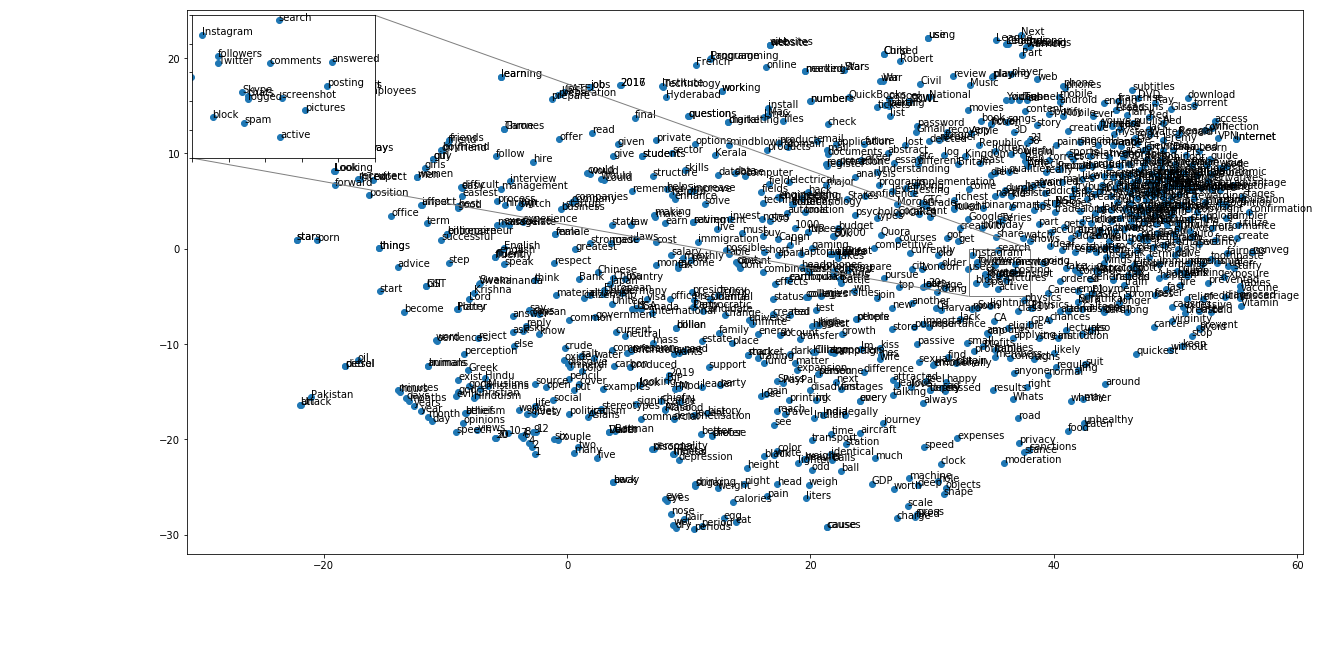

In [83]:
# Create a new plot, split into figure and axes elements
fig, ax = plt.subplots(figsize=[20,10])

# Add our data to the new plot axes
ax.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Create a new set of in-set axes, and populate with the same data
axins = zoomed_inset_axes(ax, 3, loc=2) # zoom-factor: 3, location: upper-left
axins.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Define region that we want to show in our in-set chart
x1, x2, y1, y2 = 33, 38, -5, 0 # specify the limits of our inset graph
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

# Turn off tick-marks for axes
plt.yticks(visible=False)
plt.xticks(visible=False)

# Add labeling for scatter plot points in both our large and in-set charts
vocab_word_names = list(model.wv.vocab.keys());

for label, x, y in zip(vocab_word_names, X_tsne[:, 0], X_tsne[:, 1]):
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        axins.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
# Add lines to show where inset is focused in larger plot
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

# Draw and show chart
plt.draw()
plt.show()




In the chart above, we see a two-dimensional representation of an approximation of how the first thousand word vectors are spatially arranged, from our matrix from the word2vec model. Many interesting clusters of similar kinds of words show up, highlighting areas where our word2vec model was able to learn broader topics that Quora questions commonly focused on.

The in-set chart above highlights one such cluster of words related to social media and online interactions. We see Twitter, Skype and Instagram located close together, along with words about interactions on these platforms, such as "followers", "pictures", "comments", "block" and "spam."



## Visualization 2: Measuring Time

Let's create the same chart again, but this time we will focus our in-set zoom on another interesting cluster which is less "topical" but more "functional" in the types of words it identifies as being similar.


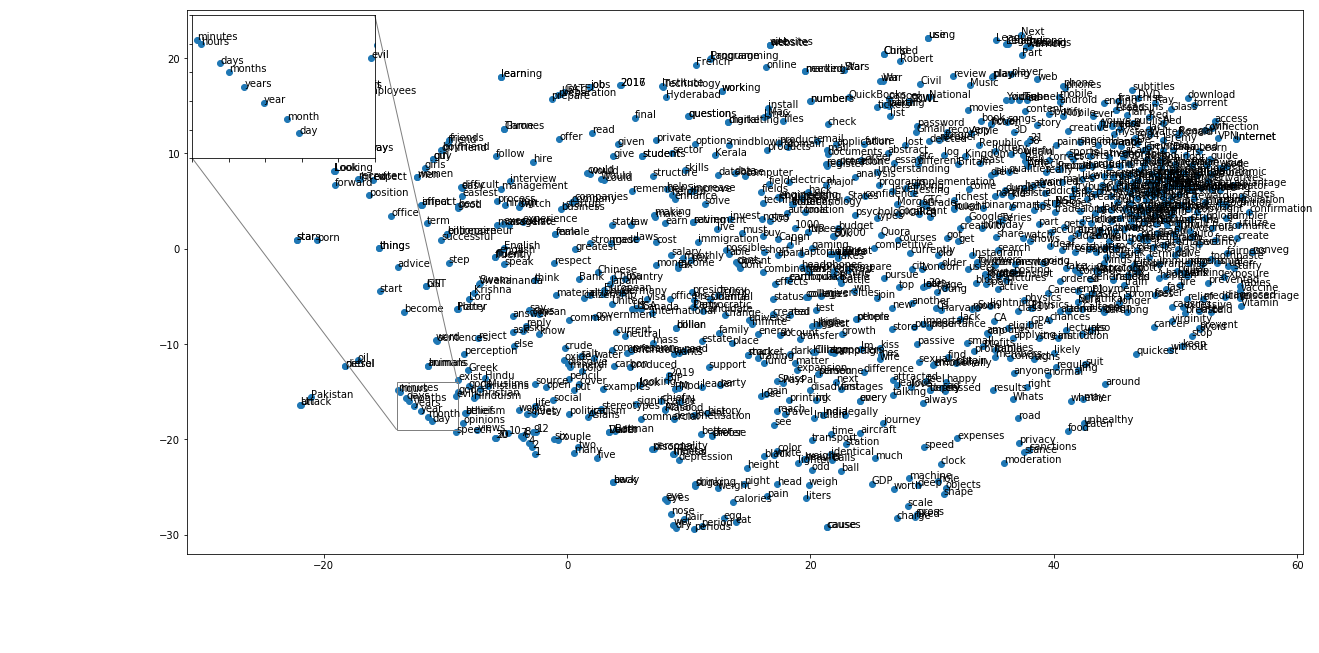

In [73]:
# Create a new plot, split into figure and axes elements
fig, ax = plt.subplots(figsize=[20,10])

# Add our data to the new plot axes
ax.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Create a new set of in-set axes, and populate with the same data
axins = zoomed_inset_axes(ax, 3, loc=2) # zoom-factor: 3, location: upper-left
axins.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Define region that we want to show in our in-set chart
x1, x2, y1, y2 = -14, -9, -19, -14 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

# Turn off tick-marks for axes
plt.yticks(visible=False)
plt.xticks(visible=False)

# Add labeling for scatter plot points in both our large and in-set charts
vocab_word_names = list(model.wv.vocab.keys());

for label, x, y in zip(vocab_word_names, X_tsne[:, 0], X_tsne[:, 1]):
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        axins.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
# Add lines to show where inset is focused in larger plot
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

# Draw and show chart
plt.draw()
plt.show()


What we see here is an interesting linear cluster of words representing different periods of time, including "minutes", "hours", "days", "months" and "years." Perhaps the word2vec model was able to pick up on contextual clues such as the words "for" and "long" in questions to identify that these words fulfilled similar functions.

If we use the "most_similar" function of our word2vec model for the word "years", we see many of the same words visible in this cluster show up.


In [75]:
model.most_similar("years")

[('yrs', 0.8314576148986816),
 ('months', 0.7631711959838867),
 ('year', 0.7351706027984619),
 ('yr', 0.7314525842666626),
 ('days', 0.7190325260162354),
 ('weeks', 0.6372518539428711),
 ('decades', 0.6279939413070679),
 ('semesters', 0.618726372718811),
 ('LPA', 0.5738800168037415),
 ('minutes', 0.5627063512802124)]

# Conclusion

As is visible from the above exploration, word2vec is a powerful tool, even with a fairly limited dataset. The model we've created could conceivably be used to evaluate similarity between words and questions, or even to create new questions. By creating vectorized representations of the words in our corpus, we are able to train our model to learn not just about word frequency, but also about contextual meanings.

t-SNE allows us to take our resulting high-dimensional matrix and create an approximation of that matrix in two dimensions. We can quickly pick out interesting topical and functional clusters of words whose distances aren't too far from each other in vector-space. This gives us a sense of the usefulness of modelling context when it comes to understanding meaning in language.